## This project use location data from multiple sources and demographics to create the shortlist for the new location of Japanese restaurant in Toronto
1. Unlike other medium - smaller cities in Canada there is plenty of data for city of Toronto available online
2. The high foot traffic based on popularity of the business venues is used as one of the selection criteria for location
3. The income, population and population density are also used to help with selection
4. The information related to 100 most commons venues will be obtained from foursquare

Setup to access data resources on IBM platform information will not visible to public users

In [1]:
# The code was removed by Watson Studio for sharing.

Downloading dependencies which are used for this projects

In [2]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge beautifulSoup4 --yes
!conda install -c conda-forge lxml --yes


!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
import requests 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from bs4 import BeautifulSoup


print('Completed importing libraries and  installation')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Completed importing libraries and  installation


Scrap Toronto postal code data from wikipedia using beautiful soup

In [3]:
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')
TNCode = soup.find('table',{'class':'wikitable sortable'})

Creating dataframe for Toronto postal code

In [4]:
columns=['Postcode','Borough','Neighbourhood']
df = pd.DataFrame(columns=columns)

for row in TNCode.findAll("tr"):
    trow=[]
    for cell in row.findAll("td"):
        trow.append(cell.text.strip())
        if len(trow)==3:
            df.loc[len(df)] = trow
print(df.shape)
df.head(15)

(288, 3)


,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


Cleaning the data frame for Postal code because it has Not assigned neighbourhood and borough

In [5]:
df=df[df['Borough']!="Not assigned"]
df.loc[(df['Neighbourhood'] == 'Not assigned'), 'Neighbourhood'] = df['Borough']
df.reset_index(drop=True,inplace=True)
print(df.shape)
df.head(15)

(211, 3)


,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [6]:
df_PC=df.sort_values('Neighbourhood')
df_PC.reset_index(drop=True, inplace=True)
df_PC.head()

,Postcode,Borough,Neighbourhood
0,M5H,Downtown Toronto,Adelaide
1,M1S,Scarborough,Agincourt
2,M1V,Scarborough,Agincourt North
3,M9V,Etobicoke,Albion Gardens
4,M8W,Etobicoke,Alderwood


Save the file to the object storage on ibm cloud, information is hidden to public users

In [7]:
# The code was removed by Watson Studio for sharing.

Completed saving the file to Object storage


Read file from object storage on ibm cloud

In [8]:
dfile = project.get_file("TorontoPostalCode2.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
dfile.seek(0)

dfu=pd.read_csv(dfile)
df_Postcode=dfu.sort_values('Neighbourhood')
df_Postcode.reset_index(drop=True,inplace=True)

In [9]:
df_Postcode.head()

,Postcode,Borough,Neighbourhood
0,M1V,Scarborough,Agincourt North
1,M1S,Scarborough,Agincourt South-Malvern West
2,M8W,Etobicoke,Alderwood
3,M5R,Central Toronto,Annex
4,M3B,North York,Banbury-Don Mills


Read csv file for Toronto neighbourhood profiles from open data Toronto website

In [10]:
#read demographic data from open data
df_TNDemographic=pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv")
df_TNDemographic.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,Beechborough-Greenbrook,Bendale,Birchcliffe-Cliffside,Black Creek,Blake-Jones,Briar Hill-Belgravia,Bridle Path-Sunnybrook-York Mills,Broadview North,Brookhaven-Amesbury,Cabbagetown-South St. James Town,Caledonia-Fairbank,Casa Loma,Centennial Scarborough,Church-Yonge Corridor,Clairlea-Birchmount,Clanton Park,Cliffcrest,Corso Italia-Davenport,Danforth,Danforth East York,Don Valley Village,Dorset Park,Dovercourt-Wallace Emerson-Junction,Downsview-Roding-CFB,Dufferin Grove,East End-Danforth,Edenbridge-Humber Valley,Eglinton East,Elms-Old Rexdale,Englemount-Lawrence,Eringate-Centennial-West Deane,Etobicoke West Mall,Flemingdon Park,Forest Hill North,Forest Hill South,Glenfield-Jane Heights,Greenwood-Coxwell,Guildwood,Henry Farm,High Park North,High Park-Swansea,Highland Creek,Hillcrest Village,Humber Heights-Westmount,Humber Summit,Humbermede,Humewood-Cedarvale,Ionview,Islington-City Centre West,Junction Area,Keelesdale-Eglinton West,Kennedy Park,Kensington-Chinatown,Kingsview Village-The Westway,Kingsway South,Lambton Baby Point,L'Amoreaux,Lansing-Westgate,Lawrence Park North,Lawrence Park South,Leaside-Bennington,Little Portugal,Long Branch,Malvern,Maple Leaf,Markland Wood,Milliken,Mimico (includes Humber Bay Shores),Morningside,Moss Park,Mount Dennis,Mount Olive-Silverstone-Jamestown,Mount Pleasant East,Mount Pleasant West,New Toronto,Newtonbrook East,Newtonbrook West,Niagara,North Riverdale,North St. James Town,Oakridge,Oakwood Village,O'Connor-Parkview,Old East York,Palmerston-Little Italy,Parkwoods-Donalda,Pelmo Park-Humberlea,Playter Estates-Danforth,Pleasant View,Princess-Rosethorn,Regent Park,Rexdale-Kipling,Rockcliffe-Smythe,Roncesvalles,Rosedale-Moore Park,Rouge,Runnymede-Bloor West Village,Rustic,Scarborough Village,South Parkdale,South Riverdale,St.Andrew-Windfields,Steeles,Stonegate-Queensway,Tam O'Shanter-Sullivan,Taylor-Massey,The Beaches,Thistletown-Beaumond Heights,Thorncliffe Park,Trinity-Bellwoods,University,Victoria Village,Waterfront Communities-The Island,West Hill,West Humber-Clairville,Westminster-Branson,Weston,Weston-Pelham Park,Wexford/Maryvale,Willowdale East,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,49,39,112,127,122,24,69,108,41,57,30,71,109,96,133,75,120,33,123,92,66,59,47,126,93,26,83,62,9,138,5,32,11,13,44,102,101,25,65,140,53,88,87,134,48,8,21,22,106,125,14,90,110,124,78,6,15,114,117,38,105,103,56,84,19,132,29,12,130,17,135,73,115,2,99,104,18,50,36,82,68,74,121,107,54,58,80,45,23,67,46,10,72,4,111,86,98,131,89,28,139,85,70,40,116,16,118,61,63,3,55,81,79,43,77,136,1,35,113,91,119,51,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,No Designation,NIA,No Designation,No Designation,No Designation,NIA,NIA,Emerging Neighbourhood,No Designation,No Designation,NIA,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,Emerging Neighbourhood,NIA,NIA,No Designation,NIA,No Designation,No Designation,NIA,NIA,No 

In [11]:
#Deleting some of the columns with information which is not needed for this project 
#and reorder the matrix in such a way rows become columns
df_TNDemographic.drop(['_id','Category','Topic','Data Source'], axis=1, inplace=True)

df_TNDemographic.set_index('Characteristic',inplace=True)
df_TNDemographic=df_TNDemographic.T

#Create a data frame that include demographic data for population, density, land area and average family income for neighbourhoods
df_TNDemographic=df_TNDemographic[['Population, 2016','Population density per square kilometre','Land area in square kilometres','  Average after-tax income of households in 2015 ($)']]
df_TNDemographic.reset_index(inplace=True)
df_TNDemographic.rename(columns={'index':'Neighbourhood','Population, 2016':'Population','Population density per square kilometre':'Density','Land area in square kilometres':'Area square km','  Average after-tax income of households in 2015 ($)':'Average Income'}, inplace=True)
print(df_TNDemographic.shape)
df_TNDemographic.head()

(141, 5)


Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,"2,731,571","4,334",630.2,"81,495"
1,Agincourt North,"29,113","3,929",7.41,"427,037"
2,Agincourt South-Malvern West,"23,757","3,034",7.83,"278,390"
3,Alderwood,"12,054","2,435",4.95,"168,602"
4,Annex,"30,526","10,863",2.81,"792,507"


Clenup and data conversion as well as removing City of Toronto from the list of neighbourhoods

In [12]:
#Cleanup and converting the number corresponding to density, population, land area and average income to int or float
df_TNDemographic['Population'] =df_TNDemographic['Population'].str.replace(',', '')
df_TNDemographic['Population'] =df_TNDemographic['Population'].astype(int)
df_TNDemographic['Average Income'] = df_TNDemographic['Average Income'].str.replace(',', '')
df_TNDemographic["Average Income"] = df_TNDemographic["Average Income"].astype(float)
df_TNDemographic['Density'] = df_TNDemographic['Density'].str.replace(',', '')
df_TNDemographic["Density"] = df_TNDemographic["Density"].astype(int)
df_TNDemographic["Area square km"] = df_TNDemographic["Area square km"].astype(float)

dfTorontoCity=df_TNDemographic[0:1]

columns=['Neighbourhood','Population','Density','Area square km','Average Income']
df_DGneigh=pd.DataFrame(data=df_TNDemographic[1:], columns=columns)
df_DGneigh.reset_index(inplace=True,drop=True)
print(df_DGneigh.shape)
df_DGneigh.head()

(140, 5)


,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,427037.0
1,Agincourt South-Malvern West,23757,3034,7.83,278390.0
2,Alderwood,12054,2435,4.95,168602.0
3,Annex,30526,10863,2.81,792507.0
4,Banbury-Don Mills,27695,2775,9.98,493486.0


In [14]:
df_DGneigh.dtypes

Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

Find statics and recalculate Toronto Density value based on its neighbourhoods value

In [15]:
IncomeTN=df_DGneigh['Average Income'].mean()

TorontoAvgIncome=dfTorontoCity['Average Income'].values[0]

# re-calculate Toronto Density value based on neighbourhoods values for population and density
PopTN=df_DGneigh['Population'].sum()
AreaTN=df_DGneigh['Area square km'].sum()
TorontoDensity=PopTN/AreaTN

print("The Average Income for City of Toronto = ", TorontoAvgIncome, "\n")
print('Estimated Values of Income, Density, and Population for Toronto')
print("The estimated Density for Neighbourhoods = ", TorontoDensity, "\n")
print("The estimated Population for Neighbourhoods = ", PopTN, "\n")
print("The estimated Average Income for Neighbourhoods = ", IncomeTN)

print("Minimum Average Income = ", df_DGneigh['Average Income'].min())

#create summary of statistics
df_DGneigh.describe()

The Average Income for City of Toronto =  81495.0 

Estimated Values of Income, Density, and Population for Toronto
The estimated Density for Neighbourhoods =  4334.175869510028 

The estimated Population for Neighbourhoods =  2731571 

The estimated Average Income for Neighbourhoods =  351276.1285714286
Minimum Average Income =  102259.0


,Population,Density,Area square km,Average Income
count,140.000000,140.000000,140.000000,1.400000e+02
mean,19511.221429,6261.135714,4.501714,3.512761e+05
std,10033.589222,4840.359075,4.544665,2.309379e+05
min,6577.000000,1040.000000,0.420000,1.022590e+05
25%,12019.500000,3595.250000,1.852500,1.953375e+05
50%,16749.500000,5071.500000,3.275000,2.915495e+05
75%,23854.500000,7621.250000,5.382500,4.305408e+05
max,65913.000000,44321.000000,36.890000,1.413132e+06


In [16]:
dfTorontoCity

Characteristic,Neighbourhood,Population,Density,Area square km,Average Income
0,City of Toronto,2731571,4334,630.2,81495.0


Divide average family income after tax by 4.31, because the calculated average for City of Toronto is 351,276 and one provided is 81,495

In [17]:
# the actual average income for Toronto after tax is $81,495 based on 2016 census and calculated average income is 352264.73
# The average income for individual neighbourhood was taken for smaller sample, however for simplicity we going to scale average income by pf

df_DGScaled=df_DGneigh

#since it is average income we can divide the Average income value to match the average of City of Toronto
pf=IncomeTN/TorontoAvgIncome
df_DGScaled['Average Income']=df_DGScaled['Average Income']/pf

print('Income Multiplying factor = ' , pf)
df_DGScaled.head()

Income Multiplying factor =  4.310400988667141


,Neighbourhood,Population,Density,Area square km,Average Income
0,Agincourt North,29113,3929,7.41,99071.293163
1,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,Alderwood,12054,2435,4.95,39115.154354
3,Annex,30526,10863,2.81,183859.228430
4,Banbury-Don Mills,27695,2775,9.98,114487.260303


Merge demographic data with postal code data by neighbourhood

In [18]:
df_PCDG = pd.merge(df_Postcode, df_DGScaled, how='inner', on = 'Neighbourhood')
print(df_PCDG.shape)
df_PCDG.head()

(132, 7)


,Postcode,Borough,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Scarborough,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Scarborough,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Etobicoke,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Central Toronto,Annex,30526,10863,2.81,183859.228430
4,M3B,North York,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [19]:
df_PCDGsorted=df_PCDG.sort_values('Neighbourhood')
df_PCDGsorted.reset_index(drop=True, inplace=True)
df_PCDGsorted.head()

,Postcode,Borough,Neighbourhood,Population,Density,Area square km,Average Income
0,M1V,Scarborough,Agincourt North,29113,3929,7.41,99071.293163
1,M1S,Scarborough,Agincourt South-Malvern West,23757,3034,7.83,64585.638490
2,M8W,Etobicoke,Alderwood,12054,2435,4.95,39115.154354
3,M5R,Central Toronto,Annex,30526,10863,2.81,183859.228430
4,M3B,North York,Banbury-Don Mills,27695,2775,9.98,114487.260303


In [20]:
df_PCDGsorted.dtypes

Postcode           object
Borough            object
Neighbourhood      object
Population          int64
Density             int64
Area square km    float64
Average Income    float64
dtype: object

Aggregate the data by unique postal code

In [21]:
#Aggregate the data by unique postal code
aggregations = {

    'Neighbourhood': lambda x: ','.join(x),
    'Population':'sum',
    'Area square km':'sum',
    'Density':'mean',
    'Average Income':'mean'
}
columns2=['Postcode', 'Borough', 'Neighbourhood','Population','Density','Area square km','Average Income']
df_PCDGAggregated=df_PCDGsorted[columns2].groupby(['Postcode','Borough']).agg(aggregations).reset_index()

#recalculate Population Density for aggregated data
df_PCDGAggregated['Density']=(df_PCDGAggregated['Population']/df_PCDGAggregated['Area square km']).astype(int)

print(df_PCDGAggregated.shape)
df_PCDGAggregated.head()

(98, 7)


,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income
0,M1B,Scarborough,"Malvern,Rouge",90290,45.74,1973,146431.388091
1,M1C,Scarborough,Highland Creek,12494,5.20,2402,45615.245662
2,M1C,Scarborough,Centennial Scarborough,13362,5.39,2479,49910.669695
3,M1E,Scarborough,"Guildwood,Morningside,West Hill",54764,19.04,2876,59286.750198
4,M1G,Scarborough,Woburn,53485,12.31,4344,145933.058584


Filter out neighbourhoods that don't meet the population > 4700, Density >2000, and Average family income after tax >70000

In [23]:
#  finding neighbourhoods with income for household >70000, Density > 2000 and population >47000
df_PCDGfiltered=df_PCDGAggregated[(df_PCDGAggregated['Average Income']>70000) &(df_PCDGAggregated['Population']>4700)  & (df_PCDGAggregated['Density']>2000)].reset_index(drop=True)


df_PCDGfiltered.sort_values('Neighbourhood')
df_PCDGfiltered.reset_index(drop=True,inplace=True)
print(df_PCDGfiltered.shape)
df_PCDGfiltered.head()

(42, 7)


,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income
0,M1G,Scarborough,Woburn,53485,12.31,4344,145933.058584
1,M1J,Scarborough,Eglinton East,22776,3.23,7051,79582.155095
2,M1L,Scarborough,Clairlea-Birchmount,26984,7.43,3631,81379.203680
3,M1N,Scarborough,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109
4,M1R,Scarborough,Wexford/Maryvale,27917,10.25,2723,78067.678827


Read csv file for geo locations (latitude, longitude) for postal code in Toronto

In [24]:
df_TNCoords=pd.read_csv("http://cocl.us/Geospatial_data")
df_TNCoords.rename(columns={'Postal Code':'Postcode'}, inplace=True)
print(df_TNCoords.shape)
df_TNCoords.head()

(103, 3)


,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the Geo coordinates by postal code, with neighbourhood, and demographic data

In [25]:
df_LocationDG = pd.merge(df_PCDGfiltered, df_TNCoords, how='inner', on = 'Postcode')
print(df_LocationDG.shape)
df_LocationDG.sort_values('Average Income',ascending = False).reset_index(drop=True)
df_LocationDG.head()

(42, 9)


,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude
0,M1G,Scarborough,Woburn,53485,12.31,4344,145933.058584,43.770992,-79.216917
1,M1J,Scarborough,Eglinton East,22776,3.23,7051,79582.155095,43.744734,-79.239476
2,M1L,Scarborough,Clairlea-Birchmount,26984,7.43,3631,81379.203680,43.711112,-79.284577
3,M1N,Scarborough,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109,43.692657,-79.264848
4,M1R,Scarborough,Wexford/Maryvale,27917,10.25,2723,78067.678827,43.750072,-79.295849


Setup Foursquare API this info are hidden to the public

In [26]:
# The code was removed by Watson Studio for sharing.

In [27]:
df_LocationDG.loc[0,'Neighbourhood']

'Woburn'

In [28]:
n_latitude = df_LocationDG.loc[0, 'Latitude'] # neighborhood latitude value
n_longitude = df_LocationDG.loc[0, 'Longitude'] # neighborhood longitude value

n_name = df_LocationDG.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(n_name, 
                                                               n_latitude, 
                                                               n_longitude))

Latitude and longitude values of Woburn are 43.7709921, -79.21691740000001.


Get to 100 most common venues information from foursquare for Roosedal-Moore Park within radius of 1 km

In [29]:
latitude=n_latitude
longitude =n_longitude
radius=1000
LIMIT=100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [30]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d5edc577f797700256ada7d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 9,
  'suggestedBounds': {'ne': {'lat': 43.77999210900001,
    'lng': -79.20447719278134},
   'sw': {'lat': 43.76199209099999, 'lng': -79.22935760721869}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cc1d28c06c254815ac18547',
       'name': 'Starbucks',
       'location': {'address': '300 Borough Dr',
        'crossStreet': 'Scarborough Town Centre',
        'lat': 43.770037201625215,
        'lng': -79.22115586641958,
        'labeledLatLngs': [{'label': 'display',


Get geo location of Toronto from geolocator.geocode

In [31]:
address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of Toronto are 43.653963, -79.387207.


Visualize the neighbourhood on map

In [32]:
map_TorontoNeighbourhoods = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(df_LocationDG['Latitude'], df_LocationDG['Longitude'], df_LocationDG['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_TorontoNeighbourhoods)  
    
map_TorontoNeighbourhoods

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(20)

,name,categories,lat,lng
0,Starbucks,Coffee Shop,43.770037,-79.221156
1,Lucky Hakka,Chinese Restaurant,43.762470,-79.214164
2,Heather Heights Park,Park,43.776594,-79.215052
3,Densgrove Park,Park,43.765397,-79.220130
4,Orton Park Guardian Pharmacy,Pharmacy,43.777723,-79.212502
5,Country Style,Coffee Shop,43.773716,-79.207027
6,Aunty Mary's,Fast Food Restaurant,43.762566,-79.215571
7,Bombay Palace,Indian Restaurant,43.767057,-79.227682
8,Bell,Electronics Store,43.776150,-79.207132


In [35]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

9 venues were returned by Foursquare.


In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
Toronto_venues = getNearbyVenues(names=df_LocationDG['Neighbourhood'],
                                   latitudes=df_LocationDG['Latitude'],
                                   longitudes=df_LocationDG['Longitude']
                                )

Woburn
Eglinton East
Clairlea-Birchmount
Birchcliffe-Cliffside
Wexford/Maryvale
Tam O'Shanter-Sullivan
Agincourt North,Milliken
L'Amoreaux,Steeles
Don Valley Village
Bayview Village,Bayview Woods-Steeles
St.Andrew-Windfields
Lansing-Westgate,Willowdale East
Westminster-Branson,Willowdale West
Parkwoods-Donalda
Banbury-Don Mills
York University Heights
Glenfield-Jane Heights
O'Connor-Parkview
East End-Danforth
The Beaches
Leaside-Bennington
South Riverdale
Lawrence Park South
Mount Pleasant East,Mount Pleasant West
Forest Hill South
Yonge-St.Clair
Rosedale-Moore Park
Church-Yonge Corridor
Waterfront Communities-The Island
Bay Street Corridor
Bedford Park-Nortown,Lawrence Park North
Annex,Casa Loma
Niagara
Corso Italia-Davenport
Palmerston-Little Italy
High Park North,High Park-Swansea,Junction Area
Roncesvalles
Kingsway South
Stonegate-Queensway
Edenbridge-Humber Valley
Eringate-Centennial-West Deane,Islington-City Centre West,Princess-Rosethorn
Willowridge-Martingrove-Richview


In [38]:
# create a dataframe of top 15 categories
Toronto_Venues_Top15 = Toronto_venues['Venue Category'].value_counts()[0:15].to_frame(name='frequency')
Toronto_Venues_Top15=Toronto_Venues_Top15.reset_index()

Toronto_Venues_Top15.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
Toronto_Venues_Top15


,Venue Category,Frequency
0,Coffee Shop,145
1,Pizza Place,64
2,Café,63
3,Park,61
4,Italian Restaurant,47
5,Grocery Store,43
6,Bakery,43
7,Japanese Restaurant,41
8,Restaurant,41
9,Sandwich Place,39


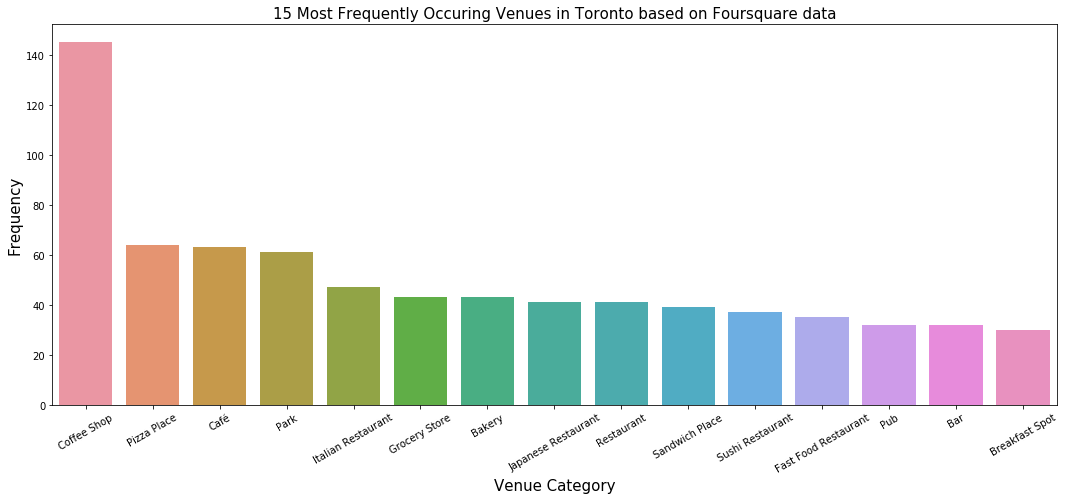

In [39]:
#Top 15 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=Toronto_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()

In [40]:
print(Toronto_venues.shape)
Toronto_venues.head(20)

(1948, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop
1,Woburn,43.770992,-79.216917,Lucky Hakka,43.762470,-79.214164,Chinese Restaurant
2,Woburn,43.770992,-79.216917,Heather Heights Park,43.776594,-79.215052,Park
3,Woburn,43.770992,-79.216917,Densgrove Park,43.765397,-79.220130,Park
4,Woburn,43.770992,-79.216917,Orton Park Guardian Pharmacy,43.777723,-79.212502,Pharmacy
5,Woburn,43.770992,-79.216917,Country Style,43.773716,-79.207027,Coffee Shop
6,Woburn,43.770992,-79.216917,Aunty Mary's,43.762566,-79.215571,Fast Food Restaurant
7,Woburn,43.770992,-79.216917,Bombay Palace,43.767057,-79.227682,Indian Restaurant
8,Woburn,43.770992,-79.216917,Bell,43.776150,-79.207132,Electronics Store
9,Eglinton East,43.744734,-79.239476,Diamond Pizza,43.743699,-79.245922,Pizza Place


In [41]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Agincourt North,Milliken",29,29,29,29,29,29
"Annex,Casa Loma",100,100,100,100,100,100
Banbury-Don Mills,31,31,31,31,31,31
Bay Street Corridor,100,100,100,100,100,100
"Bayview Village,Bayview Woods-Steeles",15,15,15,15,15,15
"Bedford Park-Nortown,Lawrence Park North",37,37,37,37,37,37
Birchcliffe-Cliffside,16,16,16,16,16,16
Church-Yonge Corridor,100,100,100,100,100,100
Clairlea-Birchmount,31,31,31,31,31,31


In [42]:
#All Restaurant venues that contain Restaurant or BBQ on their category name
Toronto_restaurants = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant|BBQ')].reset_index(drop=True)
print(Toronto_restaurants.shape)
Toronto_restaurants.head()

(504, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Woburn,43.770992,-79.216917,Lucky Hakka,43.762470,-79.214164,Chinese Restaurant
1,Woburn,43.770992,-79.216917,Aunty Mary's,43.762566,-79.215571,Fast Food Restaurant
2,Woburn,43.770992,-79.216917,Bombay Palace,43.767057,-79.227682,Indian Restaurant
3,Eglinton East,43.744734,-79.239476,Dairy Queen Restaurant,43.739506,-79.236894,Fast Food Restaurant
4,Eglinton East,43.744734,-79.239476,DQ Grill & Chill Restaurant,43.739580,-79.236991,Fast Food Restaurant


In [43]:
#count number of restaurants for each neighbourhood
TNR_count=Toronto_restaurants.groupby('Neighborhood').count()
TNR_count['Venue Category']

Neighborhood
Agincourt North,Milliken                                                        12
Annex,Casa Loma                                                                 31
Banbury-Don Mills                                                                8
Bay Street Corridor                                                             24
Bayview Village,Bayview Woods-Steeles                                            4
Bedford Park-Nortown,Lawrence Park North                                        13
Birchcliffe-Cliffside                                                            4
Church-Yonge Corridor                                                           35
Clairlea-Birchmount                                                              4
Corso Italia-Davenport                                                           6
Don Valley Village                                                               8
East End-Danforth                                                         

In [70]:
# create a dataframe of top 10 restaurants categories
TNR_Top10 = Toronto_restaurants['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
TNR_Top10=TNR_Top10.reset_index()

TNR_Top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
TNR_Top10


,Venue Category,Frequency
0,Italian Restaurant,47
1,Japanese Restaurant,41
2,Restaurant,41
3,Sushi Restaurant,37
4,Fast Food Restaurant,35
5,Thai Restaurant,28
6,Korean Restaurant,23
7,Chinese Restaurant,23
8,Vegetarian / Vegan Restaurant,19
9,American Restaurant,18


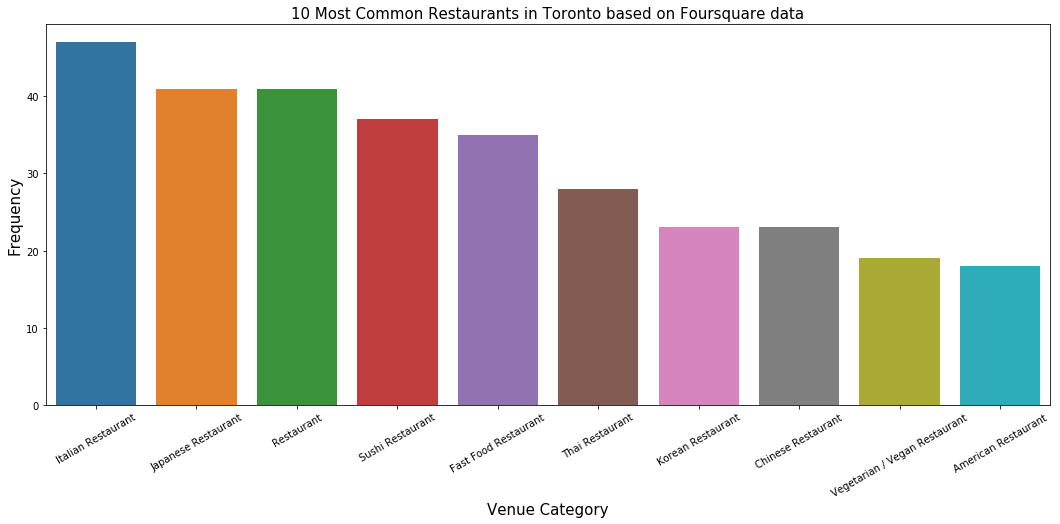

In [45]:

#Top 10 bar of the popular venue categories for the selected city
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue Category", y="Frequency", data=TNR_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('10 Most Common Restaurants in Toronto based on Foursquare data', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)

plt.show()


In [46]:
#Japanese Restaurant venues that contain Sushi or Japanese or Ramen on their category name
Toronto_Japanese_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Sushi|Japanese|Ramen')].reset_index(drop=True)
print(Toronto_Japanese_restaurant.shape)
Toronto_Japanese_restaurant.head()

(93, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Eglinton East,43.744734,-79.239476,Nakamori Japanese Restaurant,43.737003,-79.244750,Japanese Restaurant
1,Don Valley Village,43.778517,-79.346556,Heart Sushi,43.777203,-79.343805,Japanese Restaurant
2,Don Valley Village,43.778517,-79.346556,Tekka Sushi,43.774171,-79.340401,Japanese Restaurant
3,"Bayview Village,Bayview Woods-Steeles",43.786947,-79.385975,Kori Sushi,43.791613,-79.392267,Japanese Restaurant
4,"Bayview Village,Bayview Woods-Steeles",43.786947,-79.385975,Kaga Sushi,43.787758,-79.381090,Japanese Restaurant


In [47]:
#count number of japanese restaurants for each neighbourhood
Toronto_Japanese_restaurant.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Annex,Casa Loma",2,2,2,2,2,2
Banbury-Don Mills,3,3,3,3,3,3
Bay Street Corridor,6,6,6,6,6,6
"Bayview Village,Bayview Woods-Steeles",2,2,2,2,2,2
"Bedford Park-Nortown,Lawrence Park North",2,2,2,2,2,2
Church-Yonge Corridor,10,10,10,10,10,10
Corso Italia-Davenport,1,1,1,1,1,1
Don Valley Village,2,2,2,2,2,2
East End-Danforth,4,4,4,4,4,4


In [48]:
#Return locations with less than 3 Japanese restaurant
TN_JR=Toronto_Japanese_restaurant.groupby('Neighborhood').count()
TN_JR1=TN_JR[TN_JR['Venue Category']<3]
TN_JR1['Venue Category']

Neighborhood
Annex,Casa Loma                             2
Bayview Village,Bayview Woods-Steeles       2
Bedford Park-Nortown,Lawrence Park North    2
Corso Italia-Davenport                      1
Don Valley Village                          2
Eglinton East                               1
Kingsway South                              2
Rosedale-Moore Park                         1
South Riverdale                             2
York University Heights                     2
Name: Venue Category, dtype: int64

In [49]:
#Create the list of business it exclude restaurants and BBQ joints
Toronto_business = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Bank|Mall|Coffee|Café|Pizza|Cafe|Pharmacy|Storage|Tea|Grocery|Store|pub|Historic|Gym|Studio|Building|Shop|Museum|Plaza|Gallery|Business|Pub|Bar|Office|Theater')].reset_index(drop=True)
print(Toronto_business.shape)
Toronto_business.head()

(918, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Woburn,43.770992,-79.216917,Starbucks,43.770037,-79.221156,Coffee Shop
1,Woburn,43.770992,-79.216917,Orton Park Guardian Pharmacy,43.777723,-79.212502,Pharmacy
2,Woburn,43.770992,-79.216917,Country Style,43.773716,-79.207027,Coffee Shop
3,Woburn,43.770992,-79.216917,Bell,43.776150,-79.207132,Electronics Store
4,Eglinton East,43.744734,-79.239476,Diamond Pizza,43.743699,-79.245922,Pizza Place


In [50]:
#count number of business for each restaurant
TNB_count=Toronto_business.groupby('Neighborhood').count()
TNB_count['Venue Category']

Neighborhood
Agincourt North,Milliken                                                        10
Annex,Casa Loma                                                                 47
Banbury-Don Mills                                                               13
Bay Street Corridor                                                             53
Bayview Village,Bayview Woods-Steeles                                            6
Bedford Park-Nortown,Lawrence Park North                                        16
Birchcliffe-Cliffside                                                            6
Church-Yonge Corridor                                                           45
Clairlea-Birchmount                                                             13
Corso Italia-Davenport                                                          11
Don Valley Village                                                              29
East End-Danforth                                                         

In [51]:
#create a list with number of business greater than 10
TNB=TNB_count[TNB_count['Venue']>10]
TNB['Venue']

Neighborhood
Annex,Casa Loma                                    47
Banbury-Don Mills                                  13
Bay Street Corridor                                53
Bedford Park-Nortown,Lawrence Park North           16
Church-Yonge Corridor                              45
Clairlea-Birchmount                                13
Corso Italia-Davenport                             11
Don Valley Village                                 29
East End-Danforth                                  43
Forest Hill South                                  36
High Park North,High Park-Swansea,Junction Area    50
Kingsway South                                     23
Lansing-Westgate,Willowdale East                   48
Leaside-Bennington                                 36
Mount Pleasant East,Mount Pleasant West            45
Palmerston-Little Italy                            50
Parkwoods-Donalda                                  15
Roncesvalles                                       43
Rosedale-Moore 

In [52]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 256 uniques categories.


In [53]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Zoo,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,Noodle House,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Woburn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [54]:
Toronto_onehot.shape

(1948, 256)

In [55]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Zoo,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Quad,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Light Rail Station,Lighting Store,Liquor Store,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Noodle House,Office,Organic Grocery,Other Great Outdoors,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pide Place,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Ramen Restaurant,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stationery Store,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Agincourt North,Milliken",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.068966,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.034483,0.00,0.0,0.0,0.206897,0.0,0.0,0.0,0.0,0.00,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.034483,0.000000,0.0,0.

In [56]:
Toronto_grouped.shape

(42, 256)

Print the top 10 most common venues for each selected neighbourhood based on their popularity

In [57]:
num_top_venues = 10
for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North,Milliken----
                venue  freq
0  Chinese Restaurant  0.21
1              Bakery  0.07
2         Pizza Place  0.07
3   Korean Restaurant  0.07
4            Pharmacy  0.07
5        Noodle House  0.07
6                Park  0.07
7      Shop & Service  0.03
8         Event Space  0.03
9    Malay Restaurant  0.03


----Annex,Casa Loma----
                           venue  freq
0                           Café  0.05
1                    Coffee Shop  0.05
2  Vegetarian / Vegan Restaurant  0.05
3                         Bakery  0.04
4             Italian Restaurant  0.04
5                     Restaurant  0.04
6                  Grocery Store  0.03
7                            Pub  0.03
8                            Gym  0.03
9                         Museum  0.03


----Banbury-Don Mills----
                           venue  freq
0            Japanese Restaurant  0.10
1                    Pizza Place  0.06
2                    Coffee Shop  0.06
3                   

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Agincourt North,Milliken",Chinese Restaurant,Pharmacy,Bakery,Pizza Place,Park,Noodle House,Korean Restaurant,Coffee Shop,Caribbean Restaurant,Dessert Shop
1,"Annex,Casa Loma",Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bakery,Restaurant,Italian Restaurant,Pub,Museum,Gym,Grocery Store
2,Banbury-Don Mills,Japanese Restaurant,Coffee Shop,Burger Joint,Pizza Place,Salad Place,Basketball Court,Spa,Breakfast Spot,Cafeteria,Sandwich Place
3,Bay Street Corridor,Coffee Shop,Ice Cream Shop,Café,Ramen Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Park,Bubble Tea Shop,Chinese Restaurant,Gym
4,"Bayview Village,Bayview Woods-Steeles",Bank,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Skating Rink,Skate Park,Shopping Mall,Park,Trail,Café


In [60]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([0, 1, 1, 1, 0], dtype=int32)

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_LocationDG

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Toronto_merged=Toronto_merged.dropna() # check the last columns!

In [62]:
Toronto_merged['Cluster Labels']=Toronto_merged['Cluster Labels'].astype(int)

In [63]:
 #create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighbourhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [64]:
Toronto_merged.sort_values('Cluster Labels').reset_index(drop=True)
Toronto_merged.head()

,Postcode,Borough,Neighbourhood,Population,Area square km,Density,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1G,Scarborough,Woburn,53485,12.31,4344,145933.058584,43.770992,-79.216917,0,Park,Coffee Shop,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Indian Restaurant,Electronics Store,Event Space,Ethiopian Restaurant,Design Studio
1,M1J,Scarborough,Eglinton East,22776,3.23,7051,79582.155095,43.744734,-79.239476,1,Fast Food Restaurant,Bowling Alley,Convenience Store,Japanese Restaurant,Restaurant,Train Station,Sandwich Place,Coffee Shop,Pizza Place,Event Space
2,M1L,Scarborough,Clairlea-Birchmount,26984,7.43,3631,81379.203680,43.711112,-79.284577,1,Coffee Shop,Diner,Bus Line,Bakery,Convenience Store,Pharmacy,Fast Food Restaurant,Intersection,Metro Station,Mexican Restaurant
3,M1N,Scarborough,Birchcliffe-Cliffside,22291,5.92,3765,85644.236109,43.692657,-79.264848,1,College Stadium,Park,Fast Food Restaurant,Skating Rink,Diner,Café,Dessert Shop,Bank,Thai Restaurant,Restaurant
4,M1R,Scarborough,Wexford/Maryvale,27917,10.25,2723,78067.678827,43.750072,-79.295849,1,Grocery Store,Middle Eastern Restaurant,Burger Joint,Pizza Place,Intersection,Badminton Court,Soccer Field,Breakfast Spot,Fish Market,Flea Market


Cluster 0 Information

In [67]:
df_cluster0=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[2,3] + list(range(6, Toronto_merged.shape[1]))]]
df_cluster0.reset_index(drop=True, inplace=True)
df_cluster0

,Neighbourhood,Population,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Woburn,53485,145933.058584,43.770992,-79.216917,0,Park,Coffee Shop,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Indian Restaurant,Electronics Store,Event Space,Ethiopian Restaurant,Design Studio
1,"Agincourt North,Milliken",55685,110493.664337,43.815252,-79.284577,0,Chinese Restaurant,Pharmacy,Bakery,Pizza Place,Park,Noodle House,Korean Restaurant,Coffee Shop,Caribbean Restaurant,Dessert Shop
2,"Bayview Village,Bayview Woods-Steeles",34550,70518.961182,43.786947,-79.385975,0,Bank,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Skating Rink,Skate Park,Shopping Mall,Park,Trail,Café
3,"Westminster-Branson,Willowdale West",43210,70267.476459,43.782736,-79.442259,0,Pharmacy,Pizza Place,Bakery,Discount Store,Butcher,Eastern European Restaurant,Park,Bus Line,Convenience Store,Coffee Shop
4,Parkwoods-Donalda,34805,144639.211442,43.753259,-79.329656,0,Park,Pharmacy,Shopping Mall,Bus Stop,Convenience Store,Skating Rink,Tennis Court,Food & Drink Shop,Café,Supermarket
5,Glenfield-Jane Heights,30491,95121.544626,43.739015,-79.506944,0,Bank,Coffee Shop,Vietnamese Restaurant,Pizza Place,Grocery Store,Spa,Park,Shopping Mall,Dog Run,Dessert Shop
6,Corso Italia-Davenport,14133,70527.081077,43.689026,-79.453512,0,Pharmacy,Mexican Restaurant,Park,Bakery,Thai Restaurant,Market,Fast Food Restaurant,Bus Stop,Sporting Goods Shop,Beer Store
7,Stonegate-Queensway,25051,119843.838510,43.636258,-79.498509,0,Italian Restaurant,Park,Shopping Mall,Gym / Fitness Center,Eastern European Restaurant,Ice Cream Shop,Dog Run,Dessert Shop,Diner,Discount Store
8,Edenbridge-Humber Valley,15535,102322.730799,43.667856,-79.532242,0,Pharmacy,Playground,Shopping Mall,Bakery,Café,Baseball Field,Golf Course,Park,Convenience Store,Grocery Store
9,"Eringate-Centennial-West Deane,Islington-City ...",73604,134993.473120,43.650943,-79.554724,0,Park,Pizza Place,Hotel,Bank,Gym,Theater,Grocery Store,Mexican Restaurant,Fish & Chips Shop,Café


Cluster 1 Information

In [68]:
df_cluster1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[2,3] + list(range(6, Toronto_merged.shape[1]))]]
df_cluster1.reset_index(drop=True, inplace=True)
df_cluster1

,Neighbourhood,Population,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Eglinton East,22776,79582.155095,43.744734,-79.239476,1,Fast Food Restaurant,Bowling Alley,Convenience Store,Japanese Restaurant,Restaurant,Train Station,Sandwich Place,Coffee Shop,Pizza Place,Event Space
1,Clairlea-Birchmount,26984,81379.203680,43.711112,-79.284577,1,Coffee Shop,Diner,Bus Line,Bakery,Convenience Store,Pharmacy,Fast Food Restaurant,Intersection,Metro Station,Mexican Restaurant
2,Birchcliffe-Cliffside,22291,85644.236109,43.692657,-79.264848,1,College Stadium,Park,Fast Food Restaurant,Skating Rink,Diner,Café,Dessert Shop,Bank,Thai Restaurant,Restaurant
3,Wexford/Maryvale,27917,78067.678827,43.750072,-79.295849,1,Grocery Store,Middle Eastern Restaurant,Burger Joint,Pizza Place,Intersection,Badminton Court,Soccer Field,Breakfast Spot,Fish Market,Flea Market
4,Tam O'Shanter-Sullivan,27446,110348.666226,43.781638,-79.304302,1,Pharmacy,Coffee Shop,Fast Food Restaurant,Sandwich Place,Greek Restaurant,Mexican Restaurant,Italian Restaurant,Park,Shopping Mall,Seafood Restaurant
5,"L'Amoreaux,Steeles",68616,103520.299196,43.799525,-79.318389,1,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Bakery,Gym Pool,Auto Garage,Pizza Place,Other Great Outdoors,Nail Salon,Sandwich Place
6,Don Valley Village,27051,96142.099329,43.778517,-79.346556,1,Clothing Store,Coffee Shop,Fast Food Restaurant,Sandwich Place,Japanese Restaurant,Bakery,Beer Store,Caribbean Restaurant,Food Court,Department Store
7,"Lansing-Westgate,Willowdale East",66598,107678.729014,43.770120,-79.408493,1,Coffee Shop,Bubble Tea Shop,Ramen Restaurant,Korean Restaurant,Pizza Place,Fast Food Restaurant,Japanese Restaurant,Sandwich Place,Café,Sushi Restaurant
8,Banbury-Don Mills,27695,114487.260303,43.745906,-79.352188,1,Japanese Restaurant,Coffee Shop,Burger Joint,Pizza Place,Salad Place,Basketball Court,Spa,Breakfast Spot,Cafeteria,Sandwich Place
9,York University Heights,27593,70146.142040,43.767980,-79.487262,1,Coffee Shop,Furniture / Home Store,Pizza Place,Fast Food Restaurant,Metro Station,Middle Eastern Restaurant,Sports Bar,Frame Store,Sushi Restaurant,Caribbean Restaurant


Cluster 2 Information

In [69]:
df_cluster2=Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[2,3] + list(range(6, Toronto_merged.shape[1]))]]
df_cluster2.reset_index(drop=True, inplace=True)
df_cluster2

,Neighbourhood,Population,Average Income,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,St.Andrew-Windfields,17812,150633.54934,43.75749,-79.374714,2,Park,Pool,Department Store,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
